In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=d0828c8a37e4883848721ea0512f74eab696b890340ae1499ffd3c157b31d809
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [3]:
# Load the data
data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')

In [4]:
data.shape

(28800, 60)

In [5]:
data.head(2)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672


In [6]:
def kaplan(data, time_col = 'efs_time', event_col='efs'):
    
    kmf = KaplanMeierFitter()
    kmf.fit(data[time_col], event_observed=data[event_col])
    return kmf.survival_function_at_times(data[time_col]).values


data['target'] = kaplan(data=data)

In [7]:
data.shape

(28800, 61)

In [8]:
new_data = data.drop(columns=['ID', 'efs', 'efs_time'], errors='ignore', index=False)

In [9]:
new_data.shape

(28800, 58)

In [10]:
new_data.head(1)

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,target
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.458687


In [11]:
# Cleaning data: Dropping duplicate rows and irrelevant columns
data_cleaned = new_data.drop_duplicates()

# Replacing common null values in text fields and converting to lowercase
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = data_cleaned[col].str.strip().str.lower().replace(
        {'n/a': None, 'na': None, 'nan': None, '-': None})

# Filling missing values for numerical columns with their median
numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].fillna(data_cleaned[numerical_cols].mean())

# Filling missing values for categorical columns with their mode
categorical_cols = data_cleaned.select_dtypes(include='object').columns
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].apply(
    lambda col: col.fillna(col.mode()[0] if not col.mode().empty else 'unknown'))

for i in data_cleaned[categorical_cols]:
    data_cleaned[i], _ = pd.factorize(data_cleaned[i])
    


In [12]:
data_cleaned.shape

(28800, 58)

In [13]:
data_cleaned.head(3)

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,target
0,0,0,0,0,1.764516,6.876801,0,0,6.0,0,...,0,0,0,0,8.0,0,2.0,0,10.0,0.458687
1,1,0,1,0,2.000000,8.000000,1,0,6.0,1,...,0,0,1,0,8.0,0,2.0,1,10.0,0.847759
2,0,0,0,0,2.000000,8.000000,0,0,6.0,0,...,0,0,1,0,8.0,0,2.0,0,10.0,0.462424


In [14]:
# Get list of feature columns (excluding target)
feature_columns = [col for col in data_cleaned.columns if col != 'target']

for feature in feature_columns:
    correlation = data_cleaned[feature].corr(data_cleaned["target"])
    print('Correlation for ', feature, ' = ', correlation)

Correlation for  dri_score  =  -0.015663222896883162
Correlation for  psych_disturb  =  0.0445884478144293
Correlation for  cyto_score  =  0.005200974001809842
Correlation for  diabetes  =  0.06472635931119704
Correlation for  hla_match_c_high  =  -0.008997241691881857
Correlation for  hla_high_res_8  =  -0.015240185910672738
Correlation for  tbi_status  =  0.03962863015684236
Correlation for  arrhythmia  =  0.05401029510435935
Correlation for  hla_low_res_6  =  -0.008234455920193397
Correlation for  graft_type  =  0.14554016971025033
Correlation for  vent_hist  =  0.008114302625674821
Correlation for  renal_issue  =  -0.0014354737125927305
Correlation for  pulm_severe  =  0.08856949096233102
Correlation for  prim_disease_hct  =  0.022227791379227767
Correlation for  hla_high_res_6  =  -0.01698185487827107
Correlation for  cmv_status  =  -0.04700236873073342
Correlation for  hla_high_res_10  =  -0.010664416929282123
Correlation for  hla_match_dqb1_high  =  -0.008401706044617093
Correla

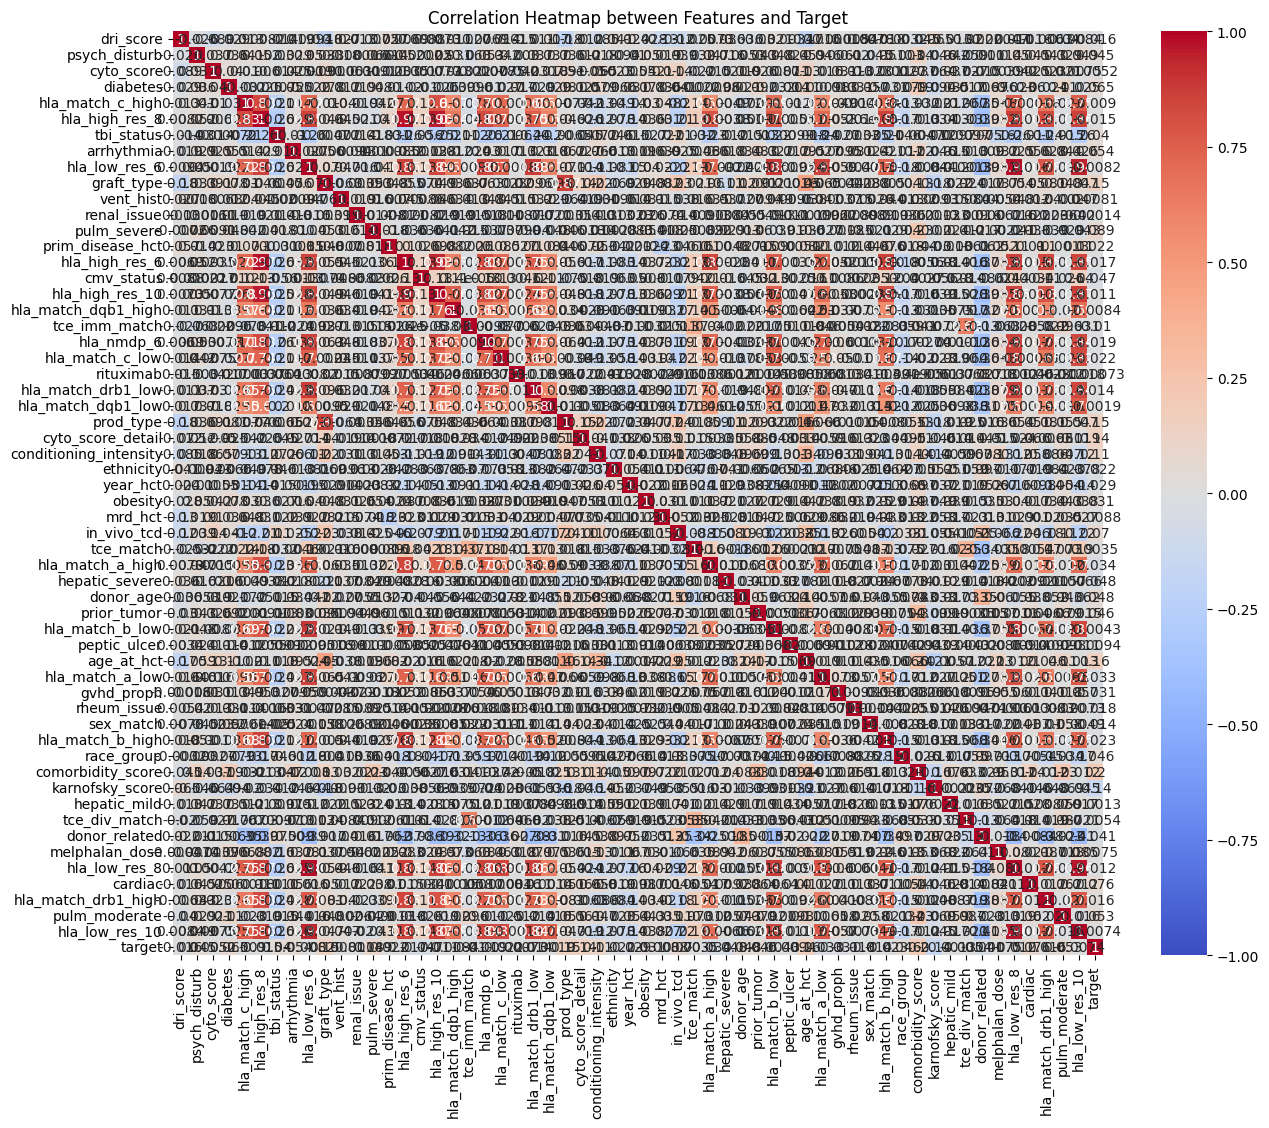

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
correlation_matrix = data_cleaned.corr()
# Set the plot size
plt.figure(figsize=(15, 12))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title
plt.title('Correlation Heatmap between Features and Target')

# Display the heatmap
plt.show()

In [16]:
# Define features and target
features = data_cleaned.drop(columns=['rituximab', 'target'], errors='ignore')
target = data_cleaned['target']

In [17]:
features

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,0,0,0,0,1.764516,6.876801,0,0,6.0,0,...,90.00000,0,0,0,0,8.0,0,2.0,0,10.0
1,1,0,1,0,2.000000,8.000000,1,0,6.0,1,...,90.00000,0,0,1,0,8.0,0,2.0,1,10.0
2,0,0,0,0,2.000000,8.000000,0,0,6.0,0,...,90.00000,0,0,1,0,8.0,0,2.0,0,10.0
3,2,0,1,0,2.000000,8.000000,0,0,6.0,0,...,90.00000,1,0,0,0,8.0,0,2.0,0,10.0
4,2,0,0,0,2.000000,8.000000,0,0,6.0,1,...,90.00000,0,0,1,1,8.0,0,2.0,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,7,0,3,0,2.000000,8.000000,0,0,6.0,1,...,83.83208,0,3,1,0,8.0,0,2.0,0,10.0
28796,2,0,0,1,1.000000,4.000000,0,0,5.0,1,...,90.00000,0,1,1,0,6.0,1,1.0,1,8.0
28797,6,0,0,0,2.000000,8.000000,0,0,6.0,1,...,90.00000,0,1,0,0,8.0,0,2.0,0,10.0
28798,0,0,0,0,1.000000,4.000000,0,0,3.0,1,...,90.00000,0,0,1,1,4.0,0,1.0,0,5.0


In [18]:
#test
df1 = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
copied_df1 = df1.copy()
df1 = df1.drop(columns=['ID', 'rituximab'], errors='ignore')

In [19]:
df1.shape

(3, 56)

In [20]:
# Cleaning data: Dropping duplicate rows and irrelevant columns
data_cleaned_t = df1.drop_duplicates()

# Replacing common null values in text fields and converting to lowercase
for col in data_cleaned_t.select_dtypes(include='object').columns:
    data_cleaned_t[col] = data_cleaned_t[col].str.strip().str.lower().replace(
        {'n/a': None, 'na': None, 'nan': None, '-': None})

# Filling missing values for numerical columns with their median
numerical_cols_t = data_cleaned_t.select_dtypes(include=['float64', 'int64']).columns
data_cleaned_t[numerical_cols_t] = data_cleaned_t[numerical_cols_t].fillna(data_cleaned_t[numerical_cols_t].mean())

# Filling missing values for categorical columns with their mode
categorical_cols_t = data_cleaned_t.select_dtypes(include='object').columns
data_cleaned_t[categorical_cols_t] = data_cleaned_t[categorical_cols_t].apply(
    lambda col: col.fillna(col.mode()[0] if not col.mode().empty else 'unknown'))

for i in data_cleaned_t[categorical_cols_t]:
    data_cleaned_t[i], _ = pd.factorize(data_cleaned_t[i])
    

In [21]:
data_cleaned_t.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,0,0,0,0,2.0,8.0,0,0,6.0,0,...,90.0,0,0,0,0,8.0,0,2.0,0,10.0
1,1,0,0,0,2.0,8.0,1,0,6.0,1,...,90.0,0,0,1,0,8.0,0,2.0,1,10.0
2,0,0,0,0,2.0,8.0,0,0,6.0,0,...,90.0,0,0,1,0,8.0,0,2.0,0,10.0


In [22]:
data_cleaned_t.shape

(3, 56)

In [23]:
model = CatBoostRegressor(random_state=42)

In [24]:

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_indices = []

    for train_index, val_index in kf.split(features):
        X_train, X_val = features.iloc[train_index], features.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Predict probabilities
        val_probabilities = model.predict(X_val)

        # Calculate C-index
        c_index = concordance_index(y_val, val_probabilities)
        c_indices.append(c_index)

    print(f"Mean Stratified C-Index: {np.mean(c_indices):.4f}")
    

Learning rate set to 0.067213
0:	learn: 0.1757251	total: 58.6ms	remaining: 58.6s
1:	learn: 0.1747578	total: 64ms	remaining: 31.9s
2:	learn: 0.1740045	total: 69.6ms	remaining: 23.1s
3:	learn: 0.1732500	total: 74.9ms	remaining: 18.6s
4:	learn: 0.1725367	total: 80.5ms	remaining: 16s
5:	learn: 0.1719783	total: 85.6ms	remaining: 14.2s
6:	learn: 0.1713835	total: 90.5ms	remaining: 12.8s
7:	learn: 0.1709070	total: 96ms	remaining: 11.9s
8:	learn: 0.1704838	total: 101ms	remaining: 11.1s
9:	learn: 0.1700060	total: 106ms	remaining: 10.5s
10:	learn: 0.1694873	total: 112ms	remaining: 10s
11:	learn: 0.1691212	total: 117ms	remaining: 9.59s
12:	learn: 0.1688524	total: 121ms	remaining: 9.2s
13:	learn: 0.1684529	total: 127ms	remaining: 8.92s
14:	learn: 0.1680779	total: 132ms	remaining: 8.67s
15:	learn: 0.1677339	total: 137ms	remaining: 8.45s
16:	learn: 0.1674288	total: 142ms	remaining: 8.24s
17:	learn: 0.1671808	total: 148ms	remaining: 8.06s
18:	learn: 0.1669675	total: 153ms	remaining: 7.88s
19:	learn: 0

In [25]:
# Train the model on the full dataset
model.fit(features, target)

Learning rate set to 0.069625
0:	learn: 0.1754932	total: 11.5ms	remaining: 11.5s
1:	learn: 0.1743871	total: 19.4ms	remaining: 9.69s
2:	learn: 0.1735191	total: 26.5ms	remaining: 8.82s
3:	learn: 0.1728188	total: 33.8ms	remaining: 8.42s
4:	learn: 0.1721705	total: 41.5ms	remaining: 8.27s
5:	learn: 0.1715416	total: 50.4ms	remaining: 8.34s
6:	learn: 0.1709544	total: 61.4ms	remaining: 8.7s
7:	learn: 0.1704380	total: 68.4ms	remaining: 8.48s
8:	learn: 0.1698911	total: 76.5ms	remaining: 8.42s
9:	learn: 0.1694270	total: 82.1ms	remaining: 8.13s
10:	learn: 0.1689362	total: 88.3ms	remaining: 7.94s
11:	learn: 0.1685655	total: 93.5ms	remaining: 7.7s
12:	learn: 0.1681741	total: 99.5ms	remaining: 7.55s
13:	learn: 0.1678761	total: 105ms	remaining: 7.4s
14:	learn: 0.1675277	total: 111ms	remaining: 7.26s
15:	learn: 0.1672086	total: 117ms	remaining: 7.17s
16:	learn: 0.1669305	total: 123ms	remaining: 7.09s
17:	learn: 0.1666938	total: 128ms	remaining: 6.99s
18:	learn: 0.1664839	total: 134ms	remaining: 6.9s
19

In [26]:
data_cleaned_t.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,0,0,0,0,2.0,8.0,0,0,6.0,0,...,90.0,0,0,0,0,8.0,0,2.0,0,10.0
1,1,0,0,0,2.0,8.0,1,0,6.0,1,...,90.0,0,0,1,0,8.0,0,2.0,1,10.0
2,0,0,0,0,2.0,8.0,0,0,6.0,0,...,90.0,0,0,1,0,8.0,0,2.0,0,10.0


In [27]:
# Prediction
copied_df1['prediction'] = model.predict(data_cleaned_t)
# Save predictions to CSV file
output_file_path = 'submission.csv'
copied_df1[['ID', 'prediction']].to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")


Predictions saved to submission.csv
